# Subtask 1C: Harmful tweet detection

In [ ]:
import re
import numpy as np
import pandas as pd

# nltk
from nltk.stem import WordNetLemmatizer

#sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
df_test = pd.read_table("CT22_english_1C_harmful_dev_test.tsv")
df_train = pd.read_table("CT22_english_1C_harmful_train.tsv")

In [ ]:
print("train size: ", df_train.shape)
print("test size: ", df_test.shape)

train size:  (3323, 5)
test size:  (910, 5)


In [ ]:
df_train.head(2)

,topic,tweet_id,tweet_url,tweet_text,class_label
0,COVID-19,1.359351e+18,http://twitter.com/user/status/135935094335617...,"India's gift of 100,000 COVID-19 vaccines arri...",0
1,COVID-19,1.350166e+18,http://twitter.com/user/status/135016568806166...,Here’s what I’m doing while I wait my turn for...,0


## Text pre processing


In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Transform words to their root form (called lemma)
def lemmatize_tweet(tweet):
    words = tweet.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

In [ ]:
def pre_process(tweet):
    
    # Remove Emojis
    emojiPattern = re.compile("[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF"
                           "\U00002500-\U00002BEF\U00002702-\U000027B0\U00002702-\U000027B0\U000024C2-\U0001F251"
                           "\U0001f926-\U0001f937\U0001F1F2-\U0001F1F4\U0001F1E6-\U0001F1FF\u2640-\u2642\u2600-\u2B55"
                           "\u200d\u23cf\u23e9\u231a\u3030]+", flags=re.UNICODE)
    tweet = re.sub(emojiPattern, '', tweet)
    
    # Remove URLs
    urlPattern = r"((http[s]?://)[^\s]*|(www\.)[^\s]*)"
    tweet = re.sub(urlPattern, '', tweet)
    
    # Remove User Mentions
    userPattern = r"@[^\s]+"
    tweet = re.sub(userPattern,'',tweet)
    
    # Lower case
    tweet = tweet.lower()
    
    # Remove sequence pattern
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
    
    # Lemmatize tweets
    # tweet = lemmatize_tweet(tweet)
        
    return tweet

In [ ]:
x_train = df_train['tweet_text'].apply(pre_process)
y_train = df_train['class_label']

In [ ]:
x_test = df_test['tweet_text'].apply(pre_process)
y_test = df_test['class_label']

In [ ]:
y_train.value_counts()

0    3031
1     292
Name: class_label, dtype: int64

<i> We can see here, that there is class imbalance in training data. This can lead to biased model performance and needs to be handled.</i>

In [ ]:
y_test.value_counts()

0    828
1     82
Name: class_label, dtype: int64

## Feature Extraction (Using CountVectorizer)

In [ ]:
# Create Vocablury (can use max_df for tuning)
vectorizer = CountVectorizer(max_df=0.95)
vectorizer.fit(x_train)
print(f'Vectoriser fitted.')
print("Vocabulary: ", len(vectorizer.vocabulary_), " words")

Vectoriser fitted.
Vocabulary:  10503  words


In [ ]:
# Transform training and testing data using the vectorizer
x_train_vector = vectorizer.fit_transform(x_train) 
x_test_vector = vectorizer.transform(x_test)
print(f'Data Transformed.')

Data Transformed.


In [ ]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(x_test_vector)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## Predicition using LinearSVC

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       828
           1       0.60      0.15      0.24        82

    accuracy                           0.91       910
   macro avg       0.76      0.57      0.59       910
weighted avg       0.89      0.91      0.89       910



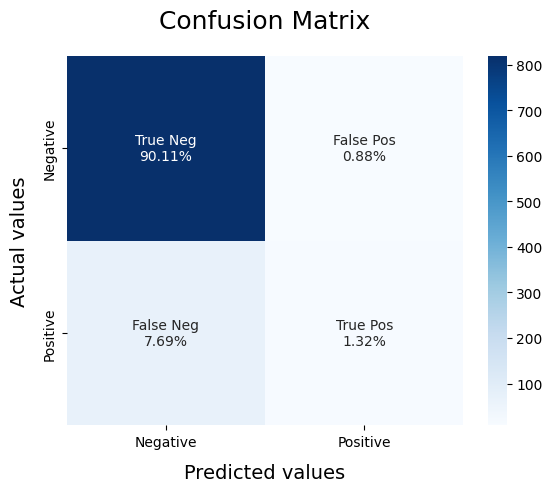

In [ ]:
classifier = LinearSVC(C=0.05, 
                       max_iter=1000)
classifier.fit(x_train_vector, y_train)
model_Evaluate(classifier)

In [ ]:
from sklearn.utils import class_weight

class_weight.compute_class_weight(class_weight = 'balanced',
                                  classes=np.unique(y_train),
                                  y= y_train)

array([0.54816892, 5.69006849])

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       828
           1       0.40      0.34      0.37        82

    accuracy                           0.89       910
   macro avg       0.67      0.65      0.66       910
weighted avg       0.89      0.89      0.89       910



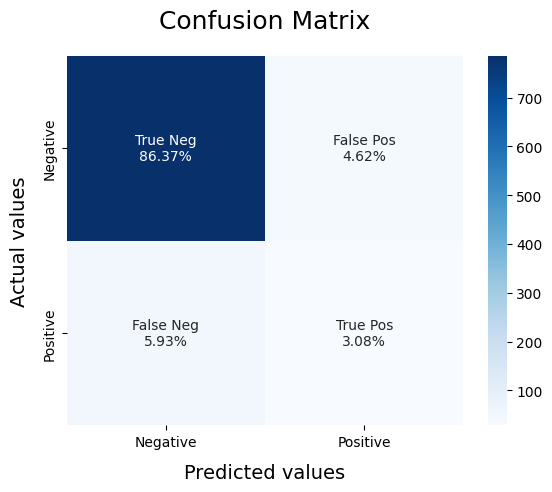

In [ ]:
classifier = LinearSVC(C=0.05, 
                       class_weight={0: 0.54816892, 1:5.69006849},
                       max_iter=1000)
classifier.fit(x_train_vector, y_train)
model_Evaluate(classifier)

## Prediction using Bernoulli model

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       828
           1       0.45      0.32      0.37        82

    accuracy                           0.90       910
   macro avg       0.69      0.64      0.66       910
weighted avg       0.89      0.90      0.90       910



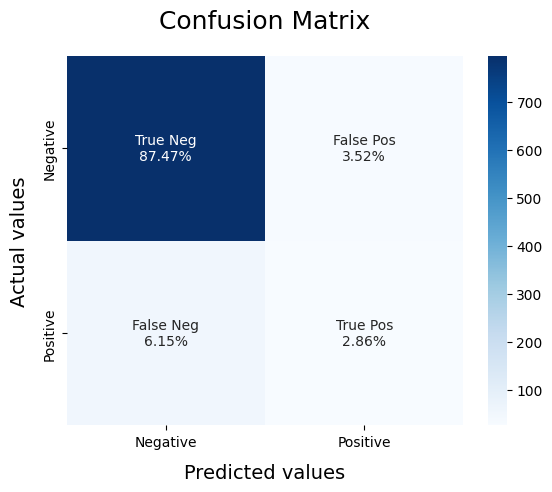

In [ ]:
classifier = BernoulliNB(alpha = 0.1)  # Tuning done on alpha -smoothing parameter - strength of regularization
classifier.fit(x_train_vector, y_train)
model_Evaluate(classifier)

Duplicate class 2 to match  class 1

In [ ]:
class_1 = df_train[df_train['class_label']== 0]
class_2 = df_train[df_train['class_label']== 1]

In [ ]:
ratio = len(class_1) / len(class_2)
ratio

10.38013698630137

In [ ]:
class_2 = pd.concat([class_2]*int(ratio), ignore_index=True)

In [ ]:
len(class_2)

2920

In [ ]:
train_df_scaled = pd.concat([class_1, class_2], ignore_index=True)

In [ ]:
x_train_scaled = train_df_scaled['tweet_text'].apply(pre_process)
y_train_scaled = train_df_scaled['class_label']

In [ ]:
y_train_scaled.value_counts()

0    3031
1    2920
Name: class_label, dtype: int64

In [ ]:
# Transform training and testing data using the vectorizer
x_train_vector_scaled = vectorizer.fit_transform(x_train_scaled) 
print(f'Data Transformed.')

Data Transformed.


### Test if scaled dataset improved bernoulli

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       828
           1       0.34      0.37      0.35        82

    accuracy                           0.88       910
   macro avg       0.64      0.65      0.64       910
weighted avg       0.88      0.88      0.88       910



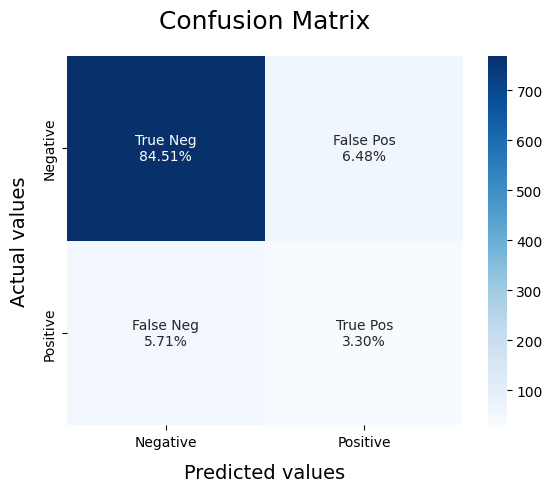

In [ ]:
classifier = BernoulliNB(alpha = 0.5)  # Tuning done on alpha -smoothing parameter - strength of regularization
classifier.fit(x_train_vector_scaled, y_train_scaled)
model_Evaluate(classifier)

# Test if scaling the dataset had an influence on SVC

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       828
           1       0.40      0.29      0.34        82

    accuracy                           0.90       910
   macro avg       0.67      0.62      0.64       910
weighted avg       0.88      0.90      0.89       910



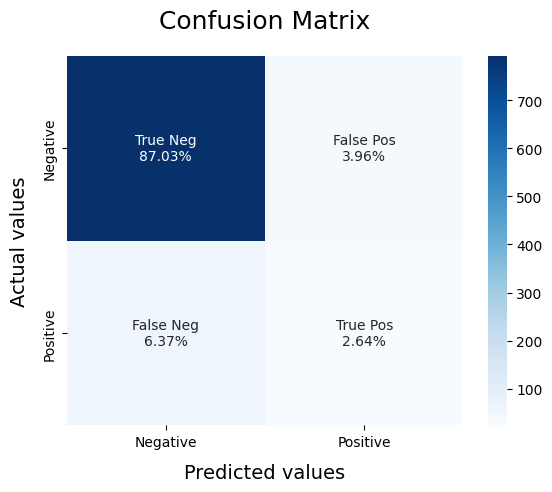

In [ ]:
classifier = LinearSVC(C=0.05, 
                       max_iter=1000, 
                       class_weight='balanced')
classifier.fit(x_train_vector_scaled, y_train_scaled)
model_Evaluate(classifier)

## Logistic Regression with Balanced class

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       828
           1       0.39      0.33      0.36        82

    accuracy                           0.89       910
   macro avg       0.66      0.64      0.65       910
weighted avg       0.89      0.89      0.89       910



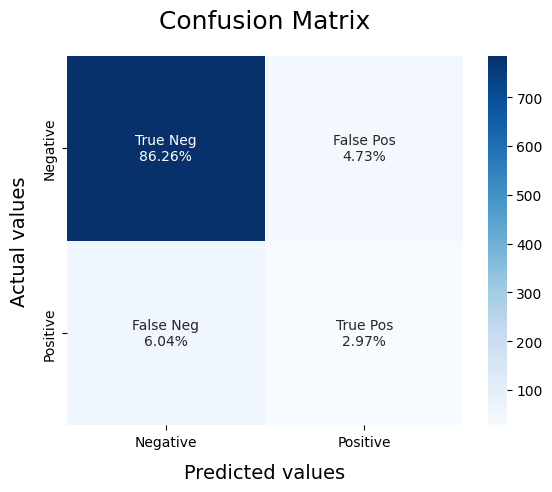

In [ ]:
classifier = LogisticRegression(class_weight='balanced')
classifier.fit(x_train_vector, y_train)
model_Evaluate(classifier)

again with scaled dataset:

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.93      0.95      0.94       828
           1       0.40      0.32      0.35        82

    accuracy                           0.90       910
   macro avg       0.67      0.63      0.65       910
weighted avg       0.89      0.90      0.89       910



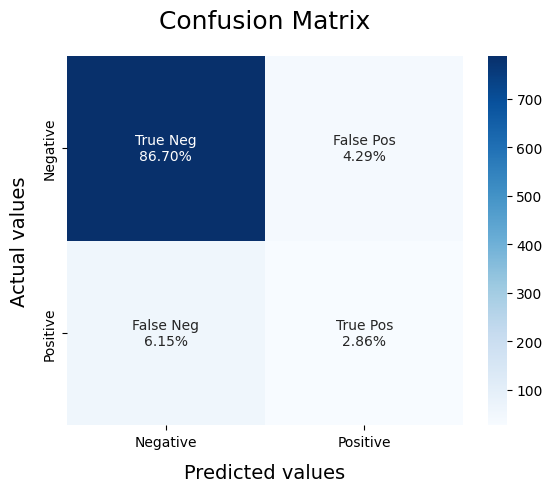

In [ ]:
classifier = LogisticRegression(class_weight='balanced')
classifier.fit(x_train_vector_scaled, y_train_scaled)
model_Evaluate(classifier)

## Feature Extraction (Using TF-IDF)

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectorizer.fit(x_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectorizer.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  66626


In [ ]:
x_train_vector = vectorizer.transform(x_train)
x_test_vector  = vectorizer.transform(x_test)
print(f'Data Transformed.')

Data Transformed.


In [ ]:
x_train_vector_scaled = vectorizer.transform(x_train_scaled)
print(f'Data Transformed.')

Data Transformed.


              precision    recall  f1-score   support

           0       0.92      0.99      0.95       828
           1       0.61      0.13      0.22        82

    accuracy                           0.91       910
   macro avg       0.77      0.56      0.59       910
weighted avg       0.89      0.91      0.89       910



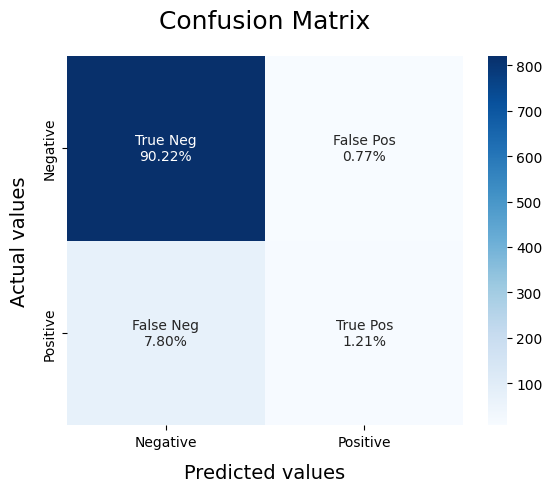

In [ ]:
classifier = BernoulliNB(alpha = 0.005)  # Tuning done on alpha -smoothing parameter - strength of regularization
classifier.fit(x_train_vector, y_train)
model_Evaluate(classifier)

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       828
           1       0.50      0.22      0.31        82

    accuracy                           0.91       910
   macro avg       0.71      0.60      0.63       910
weighted avg       0.89      0.91      0.89       910



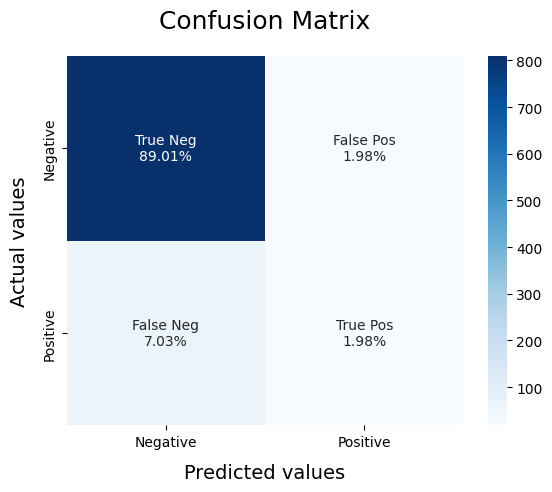

In [ ]:
classifier = BernoulliNB(alpha = 0.5)  # Tuning done on alpha -smoothing parameter - strength of regularization
classifier.fit(x_train_vector_scaled, y_train_scaled)
model_Evaluate(classifier)

LinearSVC

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       828
           1       0.62      0.06      0.11        82

    accuracy                           0.91       910
   macro avg       0.77      0.53      0.53       910
weighted avg       0.89      0.91      0.88       910



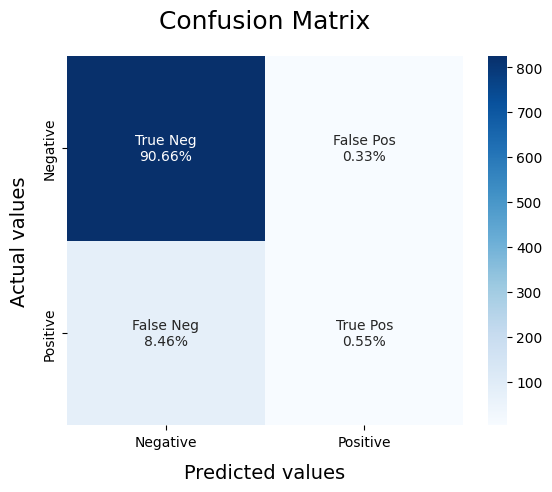

In [ ]:
classifier = LinearSVC()
classifier.fit(x_train_vector, y_train)
model_Evaluate(classifier)

              precision    recall  f1-score   support

           0       0.92      0.99      0.96       828
           1       0.63      0.15      0.24        82

    accuracy                           0.92       910
   macro avg       0.78      0.57      0.60       910
weighted avg       0.90      0.92      0.89       910



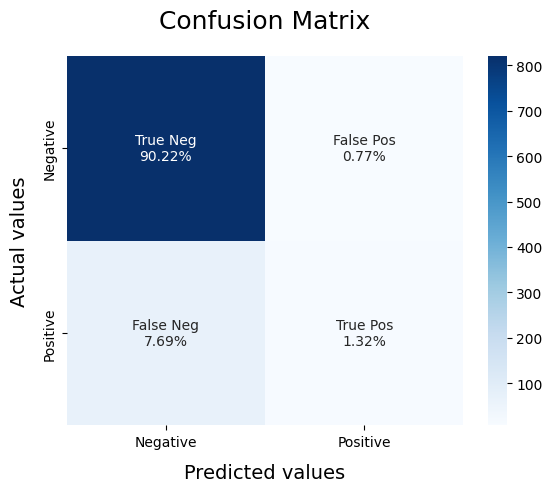

In [ ]:
classifier = LinearSVC()
classifier.fit(x_train_vector_scaled, y_train_scaled)
model_Evaluate(classifier)

## Logistic Regression Model



Logistic regressioin using C = 0.001:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       828
           1       0.33      0.44      0.38        82

    accuracy                           0.87       910
   macro avg       0.64      0.68      0.65       910
weighted avg       0.89      0.87      0.88       910



Logistic regressioin using C = 0.01:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       828
           1       0.34      0.44      0.38        82

    accuracy                           0.87       910
   macro avg       0.64      0.68      0.65       910
weighted avg       0.89      0.87      0.88       910



Logistic regressioin using C = 0.1:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       828
           1       0.35      0.45      0.39        82

    accuracy                           0.87       910
   macro av

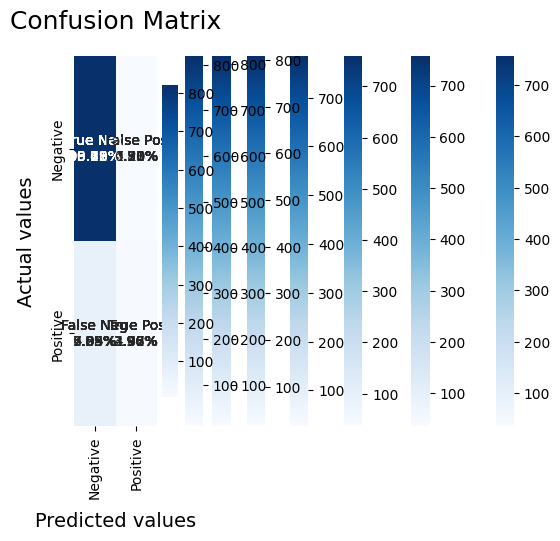

In [ ]:
C_param_range = [0.001,0.01,0.1,1,10,100,1000, 10000]
for c in C_param_range:
  print(f"\n\nLogistic regressioin using C = {c}:")
  classifier = LogisticRegression(C = c, max_iter = 10000, class_weight='balanced') # C is tuned -> inverse of the regularization strength
  classifier.fit(x_train_vector, y_train)
  model_Evaluate(classifier)

              precision    recall  f1-score   support

           0       0.92      0.99      0.96       828
           1       0.63      0.15      0.24        82

    accuracy                           0.92       910
   macro avg       0.78      0.57      0.60       910
weighted avg       0.90      0.92      0.89       910



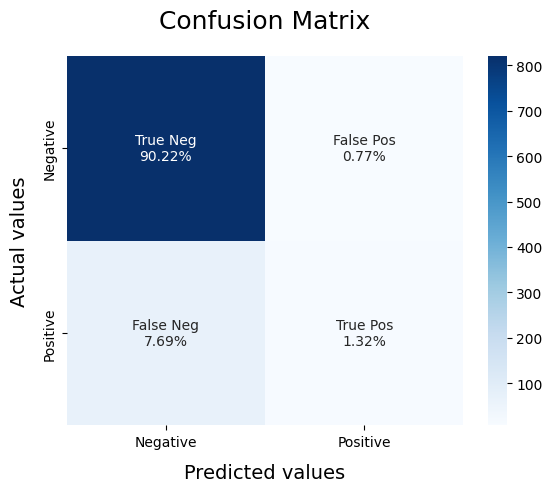

In [ ]:
classifier = LogisticRegression(C = 10000, max_iter = 10000, class_weight='balanced') # C is tuned -> inverse of the regularization strength
classifier.fit(x_train_vector, y_train)
model_Evaluate(classifier)



Logistic regressioin using C = 0.001:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       828
           1       0.33      0.44      0.38        82

    accuracy                           0.87       910
   macro avg       0.64      0.68      0.65       910
weighted avg       0.89      0.87      0.88       910



Logistic regressioin using C = 0.01:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       828
           1       0.34      0.44      0.38        82

    accuracy                           0.87       910
   macro avg       0.64      0.68      0.65       910
weighted avg       0.89      0.87      0.88       910



Logistic regressioin using C = 0.1:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       828
           1       0.37      0.44      0.40        82

    accuracy                           0.88       910
   macro av

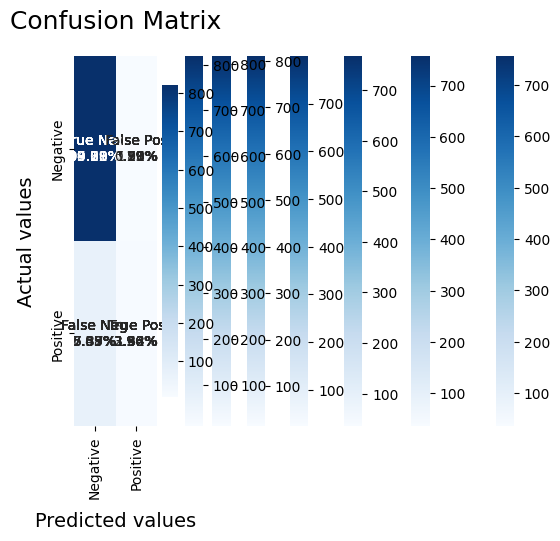

In [ ]:
C_param_range = [0.001,0.01,0.1,1,10,100,1000, 10000]
for c in C_param_range:
  print(f"\n\nLogistic regressioin using C = {c}:")
  classifier = LogisticRegression(C = c, max_iter = 10000, class_weight='balanced') # C is tuned -> inverse of the regularization strength
  classifier.fit(x_train_vector_scaled, y_train_scaled)
  model_Evaluate(classifier)

              precision    recall  f1-score   support

           0       0.92      0.99      0.96       828
           1       0.63      0.15      0.24        82

    accuracy                           0.92       910
   macro avg       0.78      0.57      0.60       910
weighted avg       0.90      0.92      0.89       910



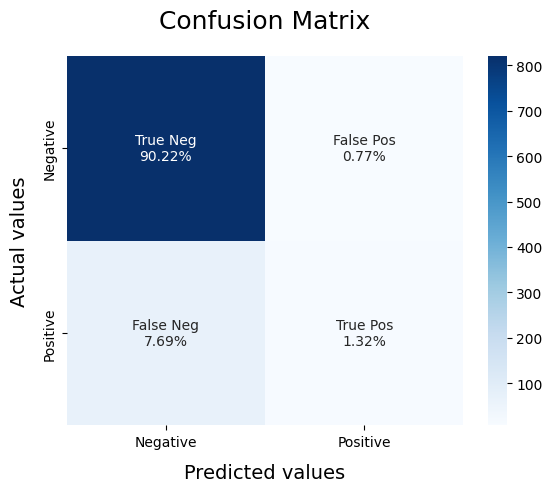

In [ ]:
classifier = LogisticRegression(C = 10000, max_iter = 10000, class_weight='balanced') # C is tuned -> inverse of the regularization strength
classifier.fit(x_train_vector_scaled, y_train_scaled)
model_Evaluate(classifier)

In [ ]:
def classBal(model,X,Y):
    if model == 'lr':
        model = LogisticRegression()
    elif model == 'svc':
        model=LinearSVC()
        


    #Setting the range for class weights
    weights = np.linspace(0.0,0.99,200)


    #Creating a dictionary grid for grid search
    param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

    #Fitting grid search to the train data with 5 folds
    gridsearch = GridSearchCV(estimator= model, 
                            param_grid= param_grid,
                            cv=StratifiedKFold(), 
                            n_jobs=-1, 
                            scoring='f1', 
                            verbose=2).fit(X,Y)
    weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
    weigh_data.score.max()
    print(weigh_data.score.max())
    for1=weigh_data.weight.where(weigh_data.score >= weigh_data.score.max() ).max()
    # print(for1)
    # print(1-for1)
    return {0: 1-for1, 1:for1}

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
0.3955676851262886
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       828
           1       0.36      0.33      0.35        82

    accuracy                           0.89       910
   macro avg       0.65      0.64      0.64       910
weighted avg       0.88      0.89      0.89       910



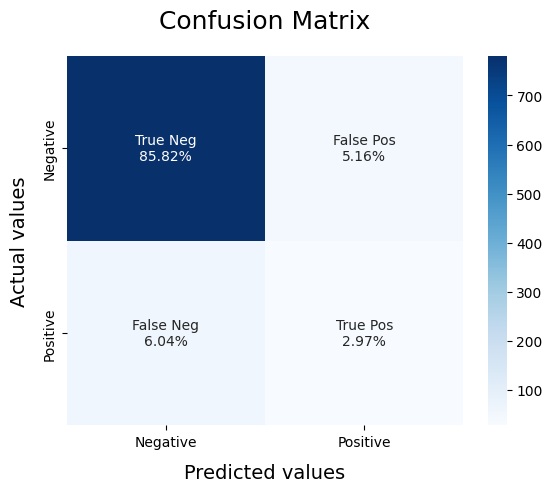

In [ ]:
class_weight=classBal('lr',x_train_vector,y_train)
classifier = LogisticRegression(C=10,class_weight=class_weight,max_iter=1000)
classifier.fit(x_train_vector, y_train)
model_Evaluate(classifier)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
0.9880380265196906
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       828
           1       0.52      0.17      0.26        82

    accuracy                           0.91       910
   macro avg       0.72      0.58      0.60       910
weighted avg       0.89      0.91      0.89       910



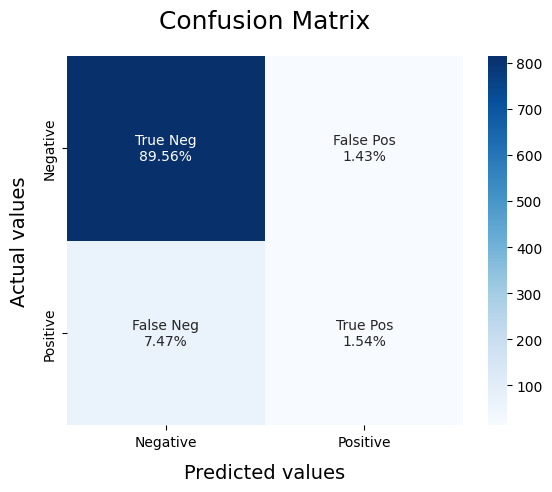

In [ ]:
class_weight=classBal('lr',x_train_vector_scaled,y_train_scaled)
classifier = LogisticRegression(C=10,class_weight=class_weight,max_iter=1000)
classifier.fit(x_train_vector_scaled, y_train_scaled)
model_Evaluate(classifier)